# Supervised learning example
Chapter 5.

Import appropriate libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn import neighbors
from sklearn import datasets

Import the data:

In [2]:
ofname = open("dataset_small.pkl", "rb")

# restructures dataset so that x is input and y is target
(x, y) = pickle.load(ofname, encoding='latin1')

Check number of features:

In [3]:
dims = x.shape[1]
N = x.shape[0]
print("dims: ", str(dims), ", samples: ", str(N))

dims:  15 , samples:  4140


Run k-nearest neighbors classifier:

In [4]:
# create instance of knn classifier
knn = neighbors.KNeighborsClassifier(n_neighbors = 11)
# train the classifier
knn.fit(x, y)
# compute prediction according to model
yhat = knn.predict(x)

# check results
print("Predicted value: ", str(yhat[-1]), ", real target: ", str(y[-1]))

# accuracy
knn.score(x, y)

Predicted value:  -1.0 , real target:  -1.0


0.83164251207729467

Checking for class imbalance:

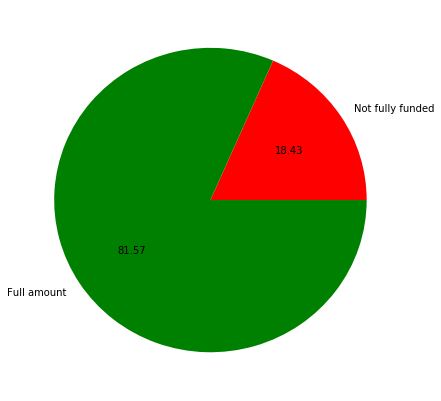

In [5]:
plt.pie(np.c_[np.sum(np.where(y == 1, 1, 0)), np.sum(np.where(y == -1, 1, 0))][0], labels = ["Not fully funded", "Full amount"], colors = ["r", "g"], shadow = False, autopct = "%.2f")
plt.gcf().set_size_inches((7, 7))

Compute confusion matrix:

In [6]:
from sklearn import metrics
metrics.confusion_matrix(yhat, y)

array([[3370,  690],
       [   7,   73]])

Compare this to a kNN with the number of neighbors equal to 1:

In [7]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 1)
knn.fit(x, y)
yhat = knn.predict(x)

print("Classification accuracy: ", str(metrics.accuracy_score(yhat, y)))
print("Confusion matrix: \n", str(metrics.confusion_matrix(yhat, y)))

Classification accuracy:  1.0
Confusion matrix: 
 [[3377    0]
 [   0  763]]


This creates a perfect score, but is likely overfitting.

Try splitting the data up into training and testing datasets:

In [8]:
perm = np.random.permutation(y.size)
PRC = 0.7
split_point = int(np.ceil(y.shape[0]*PRC))

x_train = x[perm[:split_point].ravel(), :]
y_train = y[perm[:split_point].ravel()]

x_test = x[perm[split_point:].ravel(), :]
y_test = y[perm[split_point:].ravel()]

print("Training shape: ", str(np.shape(x_train)), ", training targets shape:", str(np.shape(y_train)))
print("Testing shape: ", str(np.shape(x_test)), ", testing targets shape:", str(np.shape(y_test)))

Training shape:  (2898, 15) , training targets shape: (2898,)
Testing shape:  (1242, 15) , testing targets shape: (1242,)


Test on a kNN with 1 neighbor:

In [9]:
# Train classifier on training data
knn1 = neighbors.KNeighborsClassifier(n_neighbors = 1)
knn.fit(x_train, y_train)
yhat = knn.predict(x_train)

print("\n TRAINING STATS:")
print("Classification accuracy: ", str(metrics.accuracy_score(yhat, y_train)))
print("Confusion matrix: \n", str(metrics.confusion_matrix(yhat, y_train)))

# Train classifier on training data
knn1 = neighbors.KNeighborsClassifier(n_neighbors = 1)
yhat = knn.predict(x_test)

print("\n TESTING STATS:")
print("Classification accuracy: ", str(metrics.accuracy_score(yhat, y_test)))
print("Confusion matrix: \n", str(metrics.confusion_matrix(yhat, y_test)))


 TRAINING STATS:
Classification accuracy:  1.0
Confusion matrix: 
 [[2380    0]
 [   0  518]]

 TESTING STATS:
Classification accuracy:  0.744766505636
Confusion matrix: 
 [[849 169]
 [148  76]]


The 1 neighbor model clearly overfits the original training data and cannot respond well to new inputs.

We will randomly split the dataset and train a classifier over many times and average the performances in order to approximate the test error:

In [10]:
# splitting done by using the tools provided by sklearn:
from sklearn.cross_validation import train_test_split

PRC = 0.3
acc = np.zeros((10,))

for k in range(10):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = PRC)
    knn1 = neighbors.KNeighborsClassifier(n_neighbors = 1)
    knn.fit(x_train, y_train)
    yhat = knn.predict(x_test)
    acc[k] = metrics.accuracy_score(yhat, y_test)

acc.shape = (1, 10)
print("Mean expected error: ", str(np.mean(acc[0])))

Mean expected error:  0.752979066023


/home/jlee/anaconda3/envs/jlee_python3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We will now use two different classifiers (a decision tree and SVM) in order to perform model selection:

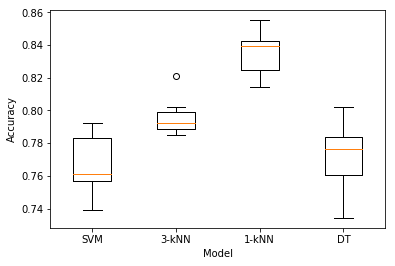

In [11]:
from sklearn import tree
from sklearn import svm

PRC = 0.1
acc_r = np.zeros((10, 4))

for k in range(10):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = PRC)
    nn1 = neighbors.KNeighborsClassifier(n_neighbors = 1)
    nn3 = neighbors.KNeighborsClassifier(n_neighbors = 3)
    svc = svm.SVC()
    dt = tree.DecisionTreeClassifier()
    
    nn1.fit(x_train, y_train)
    nn3.fit(x_train, y_train)
    svc.fit(x_train, y_train)
    dt.fit(x_train, y_train)
    
    yhat_nn1 = nn1.predict(x_test)
    yhat_nn3 = nn3.predict(x_test)
    yhat_svc = svc.predict(x_test)
    yhat_dt = dt.predict(x_test)
    
    acc_r[k][0] = metrics.accuracy_score(yhat_nn1, y_test)
    acc_r[k][1] = metrics.accuracy_score(yhat_nn3, y_test)
    acc_r[k][2] = metrics.accuracy_score(yhat_svc, y_test)
    acc_r[k][3] = metrics.accuracy_score(yhat_dt, y_test)
    
plt.boxplot(acc_r, labels = {"1-kNN", "3-kNN", "SVM", "DT"})
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

Perform cross-validation of a decision tree:

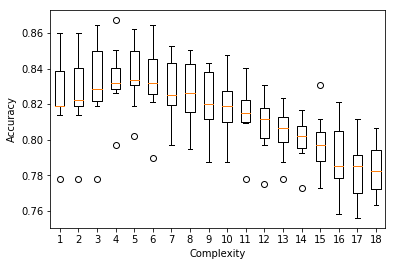

In [12]:
from sklearn import cross_validation

# create 10-fold CV set
kf = cross_validation.KFold(n = y.shape[0], n_folds = 10, shuffle = True, random_state = 0)

# search for parameter among the following
C = np.arange(2, 20,)

acc = np.zeros((10, 18))
k = 0
for train_index, val_index in kf:
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    m = 0
    
    # fit a tree for each maximum depth
    for c in C:
        dt = tree.DecisionTreeClassifier(min_samples_leaf = 1, max_depth = c)
        dt.fit(x_train, y_train)
        yhat = dt.predict(x_val)
        acc[k][m] = metrics.accuracy_score(yhat, y_val)
        m = m + 1
    k = k + 1
    
# plot accuracy
plt.boxplot(acc, labels = list(range(1, 19)))
plt.xlabel("Complexity")
plt.ylabel("Accuracy")
plt.show()

The best model could be with a maximum depth of 6. To confirm this, we will use test data:

Mean accuracy:  [ 0.77386252  0.77416463  0.77627398  0.77869363  0.78261839  0.7814072
  0.78140629  0.77808485  0.77416281  0.77174408  0.7617843   0.76088341
  0.75000819  0.74579132  0.73852965  0.7376233   0.73672424  0.73671696]
Selected model index:  4


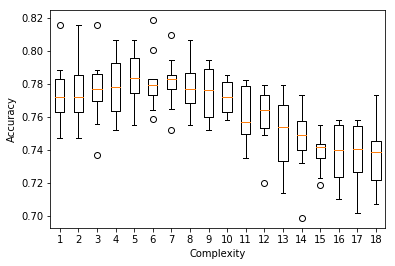

Test accuracy:  0.82729468599


In [13]:
# split the data into training and test
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size = 0.20)

# create a 10-fold CV set
kf = cross_validation.KFold(n = y_train.shape[0], n_folds = 10, shuffle = True, random_state = 0)

# search the parameter space among the following
C = np.arange(2, 20,)

acc = np.zeros((10, 18))
k = 0
for train_index, val_index in kf:
    x_train_cv, x_val = x[train_index], x[val_index]
    y_train_cv, y_val = y[train_index], y[val_index]
    
    m = 0
    
    # fit a tree for each maximum depth
    for c in C:
        dt = tree.DecisionTreeClassifier(min_samples_leaf = 1, max_depth = c)
        dt.fit(x_train_cv, y_train_cv)
        yhat = dt.predict(x_val)
        acc[k][m] = metrics.accuracy_score(yhat, y_val)
        m = m + 1
    k = k + 1
    
print("Mean accuracy: ", str(np.mean(acc, axis = 0)))
print("Selected model index: ", str(np.argmax(np.mean(acc, axis = 0))))
    
# plot accuracy
plt.boxplot(acc, labels = list(range(1, 19)))
plt.xlabel("Complexity")
plt.ylabel("Accuracy")
plt.show()

# Train the model with the complete training set with the selected complexity
dt = tree.DecisionTreeClassifier(min_samples_leaf = 1, max_depth = C[np.argmax(np.mean(acc, axis = 0))])
dt.fit(x_train, y_train)

yhat = dt.predict(x_test)
print("Test accuracy: ", str(metrics.accuracy_score(yhat, y_test)))

Train the complete dataset:

In [14]:
# Train the final model
print(type(y))
dt = tree.DecisionTreeClassifier(min_samples_leaf = 1, max_depth = C[np.argmax(np.mean(acc, axis = 0))])
dt.fit(x, y)
yhat = dt.predict(x)

print("Test accuracy: ", str(metrics.accuracy_score(yhat, y)))

<class 'numpy.ndarray'>
Test accuracy:  0.852415458937


We will select between SVM and random forest using nested CV. To accomplish this, we will perform a grid search of the parameter space:

In [ ]:
parameters = {"C": [1e4, 1e5, 1e6], "gamma": [1e-5, 1e-4, 1e-3]}
N_folds = 5

kf = cross_validation.KFold(n = y.shape[0], n_folds = N_folds, shuffle = True, random_state = 0)

acc = np.zeros((N_folds,))
k = 0

from sklearn.preprocessing import StandardScaler
from sklearn import grid_search

# build predicted y from partial predictions on the test of each fold
yhat = y.copy()
for train_index, test_index in kf:
    x_train, x_test = x[train_index, :], x[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    clf = svm.SVC(kernel = "rbf")
    clf = grid_search.GridSearchCV(clf, parameters, cv = 3)
    clf.fit(x_train, y_train.ravel())
    x_test = scaler.transform(x_test)
    yhat[test_index] = clf.predict(x_test)
    
print(str(metrics.accuracy_score(yhat, y)))
print(str(metrics.confusion_matrix(yhat, y)))

/home/jlee/anaconda3/envs/jlee_python3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
